## Install Necessary Packages

In [1]:
pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


## **Import Libraries**

In [2]:
from PIL import Image
from itertools import chain
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
# Define hyperparameters
batch_size = 64 # number of samples that will be propagated through the network
lr = 1e-4 
epoch = 12 # number of times learning algorithm will work need through the entire training dataset.
schedule = 'polynomial' # learning rate schedule

In [4]:
# Load data
data_dir = "../data"
train_labels = pd.read_csv(f'{data_dir}/train.csv')

In [5]:
# Check first 5 rows
train_labels.head()

,Image Index,Finding Labels,Patient ID,image_path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,type
0,00000001_000.png,Cardiomegaly,1,data/images-224/images-224/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,train
1,00000001_001.png,Cardiomegaly|Emphysema,1,data/images-224/images-224/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,train
2,00000001_002.png,Cardiomegaly|Effusion,1,data/images-224/images-224/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,train
3,00000004_000.png,Mass|Nodule,4,data/images-224/images-224/00000004_000.png,0,0,0,0,0,0,0,0,0,1,1,0,0,0,train
4,00000005_006.png,Infiltration,5,data/images-224/images-224/00000005_006.png,0,0,0,0,0,0,0,0,1,0,0,0,0,0,train


In [6]:
columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 
           'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [7]:
X = train_labels['image_path']
y = train_labels[columns].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=12_345)

for train_index, val_index in mskf.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=12345 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


**Data Processing and Augmentation**

Data augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation.

In [8]:
# Create function to load, process and augment CXR images
def load_image(img_file, labels):
    image = tf.io.read_file(img_file)
    image = tf.image.decode_png(image)[...,:1]
    image = tf.image.grayscale_to_rgb(image) # Convert image from grayscale to RGB
    image = tf.cast(image, tf.float32)
    image /= 255. # Standardize image pixels

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image.set_shape([224,224,3])
    
    return image, labels

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(4000).batch(batch_size).repeat()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)

## **Modelling**

I created a convolution neural network (CNN) from scratch (i.e. newly trained weights) and evaluated its performance against a transfer learning approach with the pre-trained MobileNetV2 and ResNet50 Keras applications.

Training a CNN from scratch (starting with a random initialization of weights) is often rare in practice because it is rare to obtain a large enough dataset to train. Transfer learning is the process of using pretrained weights or extracted features from a pretrained network. These pretained networks typically are very deep networks that have been trained on datasets consisting of millions of images. Rather than reinventing the wheel, we can use these networks as a basis to classify similar images since the high level features will be similar.

After some trial and error, I decided to build a simple CNN with seventeen layers (eight convolution, four batch normalization, four pooling and one dense layers) in order to minimze the number of parameters. The number of filters (each with a 3 by 3 window and stride of 1) was doubled with every pair of convolution layers to gradually identify more details from the CXR images.

In [12]:
# Instantiate learning rate scheduler

reduce_lr = tf.keras.optimizers.schedules.PolynomialDecay(lr, end_learning_rate=0,
                                                        decay_steps=epoch*(X_train.shape[0] // batch_size) + 100,
                                                        power=0.9)


####  Building CNN model

In [13]:
# Define CNN architecture 
model = tf.keras.Sequential()  

model.add(Conv2D(32,(3,3), input_shape = (224,224, 3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32,(3,3), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
# model.add(Dropout(0.25))

model.add((Conv2D(64,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add((Conv2D(64,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
# model.add(Dropout(0.25))

model.add((Conv2D(128,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add((Conv2D(128,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
# model.add(Dropout(0.25))

model.add((Conv2D(256,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add((Conv2D(256,(3,3), activation = 'relu')))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(13, activation='sigmoid'))

# Compile 
model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=reduce_lr), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

# View summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 108, 108, 64)      2

To optimize the performance of my model, I applied a 'Polynomial' learning scheduler to the Adam optimizer. Reducing the learning rate is known to improve model performace when learning plateaus. Additionally, I have implemented a callback to stop the learning algorithm from working through the dataset should the validation loss failed to improve after 4 Epochs.

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0, 
                                                  patience=4, 
                                                  verbose=1,
                                                  mode='auto'
)

In [15]:
# Fit model
history_cnn = model.fit(train_dataset,epochs=epoch, steps_per_epoch= X_train.shape[0] // batch_size, 
              validation_data = val_dataset, validation_steps = X_val.shape[0] // batch_size, 
              callbacks = [early_stopping]
)


Epoch 1/12
450/450 [==============================] - 128s 190ms/step - loss: 0.3786 - binary_accuracy: 0.8656 - val_loss: 0.3230 - val_binary_accuracy: 0.8840
Epoch 2/12
450/450 [==============================] - 129s 191ms/step - loss: 0.3200 - binary_accuracy: 0.8821 - val_loss: 0.3334 - val_binary_accuracy: 0.8780
Epoch 3/12
450/450 [==============================] - 87s 193ms/step - loss: 0.3161 - binary_accuracy: 0.8828 - val_loss: 0.3265 - val_binary_accuracy: 0.8743
Epoch 4/12
450/450 [==============================] - 87s 193ms/step - loss: 0.3118 - binary_accuracy: 0.8833 - val_loss: 0.3154 - val_binary_accuracy: 0.8785
Epoch 5/12
450/450 [==============================] - 87s 193ms/step - loss: 0.3067 - binary_accuracy: 0.8849 - val_loss: 0.3103 - val_binary_accuracy: 0.8828
Epoch 6/12
450/450 [==============================] - 87s 194ms/step - loss: 0.3016 - binary_accuracy: 0.8864 - val_loss: 0.3113 - val_binary_accuracy: 0.8842
Epoch 7/12
450/450 [========================

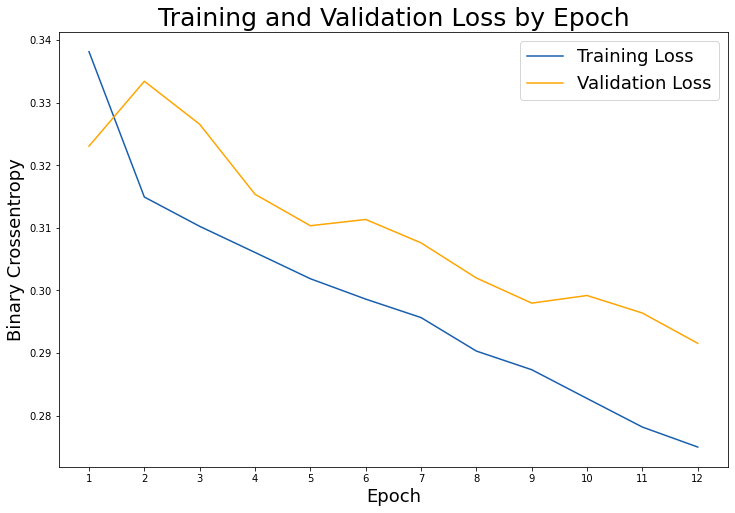

In [46]:
# Check out our train loss and test loss over epochs.
train_loss = history_cnn.history['loss']
test_loss = history_cnn.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Validation Loss', color='orange')

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(12), np.arange(12)+1)

plt.legend(fontsize = 18);

In [17]:
# Store CNN predictions
y_pred_cnn = model.predict(val_dataset, verbose = 0, batch_size = batch_size, steps = None, callbacks = None)

In [18]:
# Check prediction values
np.unique(y_pred_cnn)

array([2.1141232e-05, 2.8904158e-05, 3.7117334e-05, ..., 9.4775027e-01,
       9.4908488e-01, 9.5009714e-01], dtype=float32)

In [19]:
# Applythreshold of 0.3 to sigmoid output of indepedent probabilty for each label
y_pred_cnn = np.where(y_pred_cnn > 0.3, 1, 0)

In [20]:
# CNN Multi-label confusion matrix
multilabel_confusion_matrix(y_val, y_pred_cnn)

array([[[4320, 1228],
        [ 875,  781]],

       [[6796,   66],
        [ 295,   47]],

       [[6602,   32],
        [ 560,   10]],

       [[6882,   47],
        [ 254,   21]],

       [[4178, 1294],
        [ 679, 1053]],

       [[6910,    9],
        [ 283,    2]],

       [[6954,    0],
        [ 250,    0]],

       [[1404, 3044],
        [ 513, 2243]],

       [[6103,  295],
        [ 657,  149]],

       [[5993,  269],
        [ 851,   91]],

       [[6730,   26],
        [ 432,   16]],

       [[7027,    2],
        [ 175,    0]],

       [[6596,   81],
        [ 489,   38]]])

In [49]:
# Print CNN model classification report
print(classification_report(y_val, y_pred_cnn, target_names = columns))

                    precision    recall  f1-score   support

       Atelectasis       0.39      0.47      0.43      1656
      Cardiomegaly       0.42      0.14      0.21       342
     Consolidation       0.24      0.02      0.03       570
             Edema       0.31      0.08      0.12       275
          Effusion       0.45      0.61      0.52      1732
         Emphysema       0.18      0.01      0.01       285
          Fibrosis       0.00      0.00      0.00       250
      Infiltration       0.42      0.81      0.56      2756
              Mass       0.34      0.18      0.24       806
            Nodule       0.25      0.10      0.14       942
Pleural_Thickening       0.38      0.04      0.07       448
         Pneumonia       0.00      0.00      0.00       175
      Pneumothorax       0.32      0.07      0.12       527

         micro avg       0.41      0.41      0.41     10764
         macro avg       0.28      0.19      0.19     10764
      weighted avg       0.36      0.4

/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.


####  Transfer learning from ResNet50

In [22]:
# Define ResNet50 base model 
base_resnet = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False, 
                                               input_shape = (224, 224, 3),
                                              pooling='avg')

# Use pretrained weights in base model
#for layer in base_resnet.layers:
#    layer.trainable = False

# Inspect resnet50 model architecture 
base_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [23]:
# Define top output layer 
resnet50 = tf.keras.Sequential()
resnet50.add(base_resnet)
resnet50.add(Dropout(0.2))
resnet50.add(Dense(13, activation='sigmoid'))

# Compile model
resnet50.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

# Model summary 
resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                26637     
Total params: 23,591,437
Trainable params: 23,545,997
Non-trainable params: 45,440
_________________________________________________________________


In [24]:
# Fit model
history_resnet50 = resnet50.fit(train_dataset,epochs= epoch, steps_per_epoch= X_train.shape[0] // batch_size, 
              validation_data = val_dataset, validation_steps = X_val.shape[0] // batch_size, 
              callbacks = [early_stopping]
)

Epoch 1/12
450/450 [==============================] - 262s 302ms/step - loss: 0.3280 - binary_accuracy: 0.8707 - val_loss: 0.2840 - val_binary_accuracy: 0.8928
Epoch 2/12
450/450 [==============================] - 256s 302ms/step - loss: 0.2719 - binary_accuracy: 0.8961 - val_loss: 0.2756 - val_binary_accuracy: 0.8934
Epoch 3/12
450/450 [==============================] - 137s 304ms/step - loss: 0.2594 - binary_accuracy: 0.8989 - val_loss: 0.2829 - val_binary_accuracy: 0.8904
Epoch 4/12
450/450 [==============================] - 137s 305ms/step - loss: 0.2470 - binary_accuracy: 0.9034 - val_loss: 0.2884 - val_binary_accuracy: 0.8882
Epoch 5/12
450/450 [==============================] - 137s 304ms/step - loss: 0.2326 - binary_accuracy: 0.9087 - val_loss: 0.2811 - val_binary_accuracy: 0.8914
Epoch 6/12
450/450 [==============================] - 137s 304ms/step - loss: 0.2171 - binary_accuracy: 0.9146 - val_loss: 0.2941 - val_binary_accuracy: 0.8876
Epoch 00006: early stopping


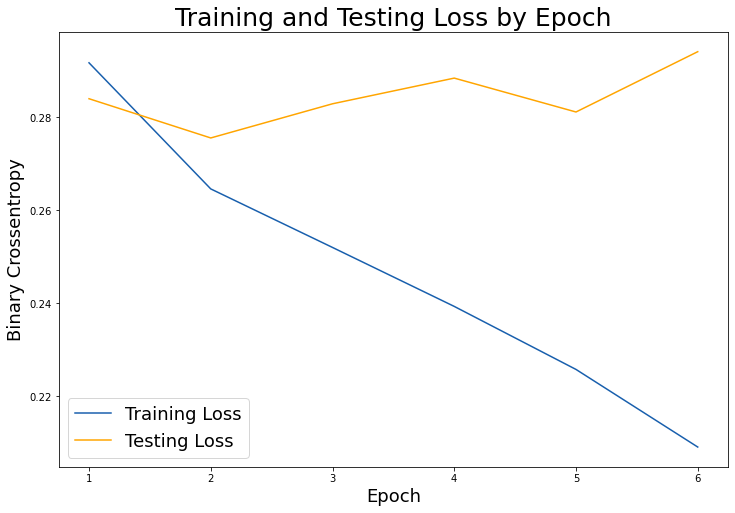

In [47]:
# Check out our train loss and test loss over epochs.
train_loss = history_resnet50.history['loss']
test_loss = history_resnet50.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(6), np.arange(6)+1)

plt.legend(fontsize = 18);

In [26]:
# Store ResNet50 predictions
y_pred_resnet50 = resnet50.predict(val_dataset, verbose = 0, batch_size = batch_size, steps = None, callbacks = None)

In [27]:
# Check prediction values
np.unique(y_pred_resnet50)

array([2.0991406e-06, 3.8556345e-06, 4.2389970e-06, ..., 9.9959368e-01,
       9.9975330e-01, 9.9990392e-01], dtype=float32)

In [30]:
# Apply threshold of 0.3 to sigmoid output of indepedent probabilty for each label
y_pred_resnet50 = np.where(y_pred_resnet50 > 0.3, 1, 0)

In [31]:
# ResNet50 Multi-label confusion matrix
multilabel_confusion_matrix(y_val, y_pred_resnet50)

array([[[4978,  570],
        [1028,  628]],

       [[6628,  234],
        [ 188,  154]],

       [[6564,   70],
        [ 544,   26]],

       [[6764,  165],
        [ 199,   76]],

       [[4570,  902],
        [ 562, 1170]],

       [[6702,  217],
        [ 181,  104]],

       [[6935,   19],
        [ 239,   11]],

       [[1198, 3250],
        [ 283, 2473]],

       [[6299,   99],
        [ 636,  170]],

       [[5932,  330],
        [ 755,  187]],

       [[6541,  215],
        [ 383,   65]],

       [[7028,    1],
        [ 175,    0]],

       [[6166,  511],
        [ 298,  229]]])

In [50]:
# Print ResNet50 classification report
print(classification_report(y_val, y_pred_resnet50, target_names = columns))

                    precision    recall  f1-score   support

       Atelectasis       0.52      0.38      0.44      1656
      Cardiomegaly       0.40      0.45      0.42       342
     Consolidation       0.27      0.05      0.08       570
             Edema       0.32      0.28      0.29       275
          Effusion       0.56      0.68      0.62      1732
         Emphysema       0.32      0.36      0.34       285
          Fibrosis       0.37      0.04      0.08       250
      Infiltration       0.43      0.90      0.58      2756
              Mass       0.63      0.21      0.32       806
            Nodule       0.36      0.20      0.26       942
Pleural_Thickening       0.23      0.15      0.18       448
         Pneumonia       0.00      0.00      0.00       175
      Pneumothorax       0.31      0.43      0.36       527

         micro avg       0.45      0.49      0.47     10764
         macro avg       0.36      0.32      0.31     10764
      weighted avg       0.44      0.4

/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####  Transfer learning from MobileNetV2

In [34]:
# Define MobileNetV2 top output layer 
base_mobilenetv2 = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, 
                                                   pooling='avg',
                                                   input_shape = (224, 224, 3))
mobilenetv2 = tf.keras.Sequential()
mobilenetv2.add(base_mobilenetv2)
mobilenetv2.add(Dropout(0.2))
mobilenetv2.add(Dense(13, activation='sigmoid'))

# Compile model
mobilenetv2.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

# Model summary
mobilenetv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                16653     
Total params: 2,274,637
Trainable params: 2,240,525
Non-trainable params: 34,112
_________________________________________________________________


In [37]:
# Fit model
history_dn = mobilenetv2.fit(train_dataset,epochs= epoch, steps_per_epoch= X_train.shape[0] // 64, 
              validation_data = val_dataset, validation_steps = X_val.shape[0] // 64, 
              callbacks = [early_stopping]
)

Epoch 1/12
450/450 [==============================] - 229s 290ms/step - loss: 0.3466 - binary_accuracy: 0.8606 - val_loss: 0.4125 - val_binary_accuracy: 0.8386
Epoch 2/12
450/450 [==============================] - 228s 293ms/step - loss: 0.2809 - binary_accuracy: 0.8927 - val_loss: 0.3226 - val_binary_accuracy: 0.8862
Epoch 3/12
450/450 [==============================] - 133s 295ms/step - loss: 0.2663 - binary_accuracy: 0.8973 - val_loss: 0.3212 - val_binary_accuracy: 0.8852
Epoch 4/12
450/450 [==============================] - 133s 295ms/step - loss: 0.2564 - binary_accuracy: 0.9004 - val_loss: 0.3076 - val_binary_accuracy: 0.8848
Epoch 5/12
450/450 [==============================] - 133s 295ms/step - loss: 0.2458 - binary_accuracy: 0.9037 - val_loss: 0.3645 - val_binary_accuracy: 0.8706
Epoch 6/12
450/450 [==============================] - 133s 296ms/step - loss: 0.2348 - binary_accuracy: 0.9074 - val_loss: 0.3238 - val_binary_accuracy: 0.8812
Epoch 7/12
450/450 [====================

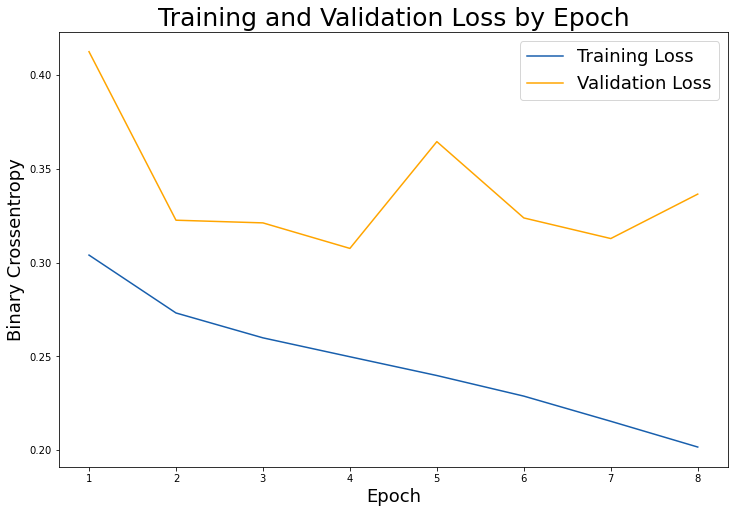

In [48]:
# Check out our train loss and test loss over epochs.
train_loss = history_dn.history['loss']
test_loss = history_dn.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Validation Loss', color='orange')

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(np.arange(8), np.arange(8)+1)

plt.legend(fontsize = 18);

In [41]:
# Store MobileNetV2 predictions
y_pred_mobilenetv2 = mobilenetv2.predict(val_dataset, verbose = 0, batch_size = batch_size, steps = None, callbacks = None)

In [42]:
# Check prediction values 
np.unique(y_pred_mobilenetv2)

array([2.4677133e-06, 3.6261165e-06, 4.2249162e-06, ..., 9.9777311e-01,
       9.9877530e-01, 9.9951363e-01], dtype=float32)

In [43]:
# Apply threshold of 0.3 to sigmoid output of indepedent probabilty for each label
y_pred_mobilenetv2 = np.where(y_pred_mobilenetv2 > 0.3, 1, 0)

In [44]:
# MobileNetV2 Multi-label confusion matrix
multilabel_confusion_matrix(y_val, y_pred_mobilenetv2)

array([[[5384,  164],
        [1377,  279]],

       [[6857,    5],
        [ 323,   19]],

       [[6620,   14],
        [ 568,    2]],

       [[6789,  140],
        [ 219,   56]],

       [[5288,  184],
        [1215,  517]],

       [[5228, 1691],
        [  68,  217]],

       [[6942,   12],
        [ 242,    8]],

       [[2835, 1613],
        [1142, 1614]],

       [[6226,  172],
        [ 629,  177]],

       [[6156,  106],
        [ 833,  109]],

       [[6547,  209],
        [ 388,   60]],

       [[7029,    0],
        [ 175,    0]],

       [[5735,  942],
        [ 245,  282]]])

In [51]:
# Print MobileNetV2 classification report
print(classification_report(y_val, y_pred_mobilenetv2, target_names = columns))

                    precision    recall  f1-score   support

       Atelectasis       0.63      0.17      0.27      1656
      Cardiomegaly       0.79      0.06      0.10       342
     Consolidation       0.12      0.00      0.01       570
             Edema       0.29      0.20      0.24       275
          Effusion       0.74      0.30      0.42      1732
         Emphysema       0.11      0.76      0.20       285
          Fibrosis       0.40      0.03      0.06       250
      Infiltration       0.50      0.59      0.54      2756
              Mass       0.51      0.22      0.31       806
            Nodule       0.51      0.12      0.19       942
Pleural_Thickening       0.22      0.13      0.17       448
         Pneumonia       0.00      0.00      0.00       175
      Pneumothorax       0.23      0.54      0.32       527

         micro avg       0.39      0.31      0.35     10764
         macro avg       0.39      0.24      0.22     10764
      weighted avg       0.50      0.3

/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/daryl/anaconda3/envs/tfsandbox/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

## Model Evaluation

Among the three models, ResNet50 transfer learning model suffered the most from overfitting as illustrated by the divergence between the training and validation loss in subsequent epochs of training. This suggested that it has learned the training data too well, including noise or random fluctuations. The overfitting is expected as ResNet50 is a relatively large model. The number of layers or parameters are a few more times greater than the CNN model I built and the MobileNetV2 transfer learning model. 

Macro-averaging is a single performance indicator obtained by averaging the score of individual classes. Macro-averaging is preferred over micro-averaging in this case of imbalanced classes because it weighs each of the classes equally and is not influenced by the number of examples of each class. I evaluated my models against macro-average recall and F1 score. In this case of a multi-label classification of thoracic pathology, I believe that the algorithm's ability to detect positive in any of the thirteen labels would help to alert or draw immediate attention from phyisicians on any abnormal thorax findings in a patient's CXR study. In another way, this can also help reporting physicians to better prioritize the order in which they should close the CXR report and intervene more timely, if necessary. Despite ResNet50 being the most overfited model, it yielded the highest macro-average recall and F1 score of 0.32 and 0.31 respectively. The poor performances yielded by all three models are not completely unexpected due to the following few reasons. One, the degree of underrepresented labels are consistently high across the thirteen labels. Two, the spatial dimensions of a CXR image are usually 2,000 by 3,000 pixels. A lot of details and information are lost when the CXR images are resized to 224 by 224 pixels.

## Conclusion 

With greater access to a graphic processing unit, my next step would be to fine-tune existing models and train them with CXR images in their dimensions. I would also like to address the issue of imbalanced labels by applying over-sampling technique such as Variational Autoencoders (VAE), Synthetic Minority Over-Sampling Technique (SMOTE) or Modified Synthetic Minority (MSMOTE). Collecting more CXR images of underrepresented labels is another viable way to address the issue of imbalanced labels but this take more time. Should there be signicant improvement to the performance of the models in future works, such computer-aided diagnosis can be extended to other medical specialties like Orthopaedics and Cardiology, where the use of X-Ray images to detect disease/defect is very common. In the context of Singapore, there still exists a gap between research and application of such deep learning algorithms in the field of computer-aided diagnosis. To overcome adoption barriers such as medicolegal, regulatory and patient-safety issues, it is imperative to design model with patient-safety at the core and test it on real-life cases in a safe and controlled environment.

#### References

[1] Bloom B, Jones LI, Freeman G. Summary health statistics for U.S. children: National Health Interview Survey, 2012. National Center for Health Statistics. Vital Health Stat 10(258). 2013.

[2] Blackwell DL, Lucas JW, Clarke TC. Summary health statistics for U.S. adults: National Health Interview Survey, 2012. National Center for Health Statistics. Vital Health Stat 10(260). 2014.

[3] National Institutes of Health, National Heart, Lung, and Blood Institute (NHLBI). Morbidity and mortality: 2012 chart book on cardiovascular, lung and blood diseases. Bethesda, MD: NHLBI; 2012 Feb. Available from: https://www.nhlbi.nih.gov/files/docs/research/2012_ChartBook_508.pdf

[4] National Institutes of Health, National Heart, Lung, and Blood Institute (NHLBI). Morbidity and mortality: 2009 chart book on cardiovascular, lung and blood diseases. Bethesda, MD: NHLBI; 2009 Oct. Available from: http://www.nhlbi.nih.gov/resources/docs/cht-book.htm

[5] Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, Ronald Summers, ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, IEEE CVPR, pp. 3462-3471, 2017

[6] Hoo-chang Shin, Kirk Roberts, Le Lu, Dina Demner-Fushman, Jianhua Yao, Ronald M. Summers, Learning to Read Chest X-Rays: Recurrent Neural Cascade Model for Automated Image Annotation, IEEE CVPR, pp. 2497-2506, 2016

[7] Open-i: An open access biomedical search engine. https: //openi.nlm.nih.gov